# Feature Engineering & Selection
If Exploration Data Analysis (EDA) is the "Story" of the dataset, then Feature Engineering is the "Screenplay"—it is the process of taking that raw story and structuring it so that a specific audience (the Machine Learning model) can understand the plot, recognize the characters, and predict the ending.


This notebook demonstrates robust feature engineering and selection for the Amazon e-commerce dataset, including:
- Scaling (StandardScaler, MinMaxScaler)
- Encoding (OneHot, Label)
- Binning (price brackets)
- Domain features (ratios, aggregations)
- Feature selection (correlation, RFE, Lasso)
- Dimensionality reduction (PCA, t-SNE)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import os
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('../src')
import importlib
import data_preprocessing
import pandas as pd
import os

# Load dataset
df = pd.read_parquet('../app/dataset/product_features.parquet')

CATEGORICAL_COLS = ['category']
NUMERICAL_COLS = ['discounted_price', 'actual_price', 'rating', 'rating_count', 'discount_percentage']
# Path to saved preprocessor
_encoder_path = os.path.join(os.path.dirname(os.path.abspath("../src/feature_engineering.py")), '../app/dataset/preprocessor.joblib')
_abs_encoder_path = os.path.abspath(_encoder_path)

Converting categorical data (like product categories) into numerical format using One-Hot Encoding.

In [3]:
# Clean numeric columns
for col in NUMERICAL_COLS:
    if col in df.columns:
        # Ensure column is string before trying to replace
        df[col] = df[col].astype(str).str.replace(',', '', regex=False)
        df[col] = df[col].str.replace('%', '', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill any NaNs that might have been created
df[NUMERICAL_COLS] = df[NUMERICAL_COLS].fillna(0)

print("Numeric columns cleaned.")

Numeric columns cleaned.


In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Scaling: StandardScaler and MinMaxScaler for price columns
scaling_cols_standard = ['discounted_price', 'actual_price', 'rating_count']
scaling_cols_minmax = ['discount_percentage', 'rating']
for col in scaling_cols_standard:
    if col in df.columns:
        scaler = StandardScaler()
        df[f'{col}_scaled'] = scaler.fit_transform(df[[col]])
for col in scaling_cols_minmax:
    if col in df.columns:
        minmax = MinMaxScaler()
        df[f'{col}_minmax'] = minmax.fit_transform(df[[col]])

# Print summary for all scaled columns that actually exist in df
scaled_cols = [
    'discounted_price_scaled', 'actual_price_scaled', 'rating_count_scaled',
    'discount_percentage_minmax', 'rating_minmax'
]
for col in scaled_cols:
    if col in df.columns:
        print(f"\n{col}:")
        print(df[col].describe().to_string())
    else:
        print(f"\n{col} does not exist in df.")


discounted_price_scaled:
count    1.351000e+03
mean     2.103753e-17
std      1.000370e+00
min     -4.553758e-01
25%     -4.121483e-01
50%     -3.354543e-01
75%     -1.576636e-01
max      1.041440e+01

actual_price_scaled:
count    1.351000e+03
mean    -1.051877e-17
std      1.000370e+00
min     -5.039348e-01
25%     -4.272502e-01
50%     -3.478013e-01
75%     -9.946801e-02
max      1.196721e+01

rating_count_scaled:
count    1.351000e+03
mean    -2.103753e-17
std      1.000370e+00
min     -4.184465e-01
25%     -3.924516e-01
50%     -3.059639e-01
75%     -3.855638e-02
max      9.722400e+00

discount_percentage_minmax:
count    1351.000000
mean        0.496598
std         0.230034
min         0.000000
25%         0.329787
50%         0.521277
75%         0.659574
max         1.000000

rating_minmax:
count    1351.000000
mean        0.817765
std         0.063498
min         0.000000
25%         0.780000
50%         0.820000
75%         0.860000
max         1.000000


In [5]:
# Categorical and Numerical columns for preprocessing
# # Encoding: OneHot for category, Label for product_name
import sys
sys.path.append(os.path.abspath('../src'))
from feature_engineering import build_and_save_preprocessor

# Call the preprocessor builder directly (no need to import the whole module again)
preprocessor, df_encoded = build_and_save_preprocessor(df, CATEGORICAL_COLS, NUMERICAL_COLS)
display(df_encoded.head())
df_encoded.info()

,cat__category_Car&Motorbike|CarAccessories|InteriorAccessories|AirPurifiers&Ionizers,cat__category_Computers&Accessories|Accessories&Peripherals|Adapters|USBtoUSBAdapters,cat__category_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|PCHeadsets,cat__category_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|PCMicrophones,cat__category_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|PCSpeakers,cat__category_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|Webcams&VoIPEquipment|Webcams,cat__category_Computers&Accessories|Accessories&Peripherals|Cables&Accessories|CableConnectionProtectors,cat__category_Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|DVICables,cat__category_Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|EthernetCables,cat__category_Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|SATACables,...,"cat__category_OfficeProducts|OfficePaperProducts|Paper|Stationery|Pens,Pencils&WritingSupplies|Pens&Refills|GelInkRollerballPens","cat__category_OfficeProducts|OfficePaperProducts|Paper|Stationery|Pens,Pencils&WritingSupplies|Pens&Refills|LiquidInkRollerballPens","cat__category_OfficeProducts|OfficePaperProducts|Paper|Stationery|Pens,Pencils&WritingSupplies|Pens&Refills|RetractableBallpointPens","cat__category_OfficeProducts|OfficePaperProducts|Paper|Stationery|Pens,Pencils&WritingSupplies|Pens&Refills|StickBallpointPens",cat__category_Toys&Games|Arts&Crafts|Drawing&PaintingSupplies|ColouringPens&Markers,num__discounted_price,num__actual_price,num__rating,num__rating_count,num__discount_percentage
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.391232,-0.418333,0.350302,3.849315,0.153585
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.491258,1.721702,0.350302,0.361522,-0.123998
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.142648,1.275059,0.665388,-0.306748,-0.216526
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.630701,1.275862,0.350302,0.410424,-1.003011
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.140687,3.594234,0.350302,-0.245115,-0.864219


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351 entries, 0 to 1350
Columns: 216 entries, cat__category_Car&Motorbike|CarAccessories|InteriorAccessories|AirPurifiers&Ionizers to num__discount_percentage
dtypes: float64(216)
memory usage: 2.2 MB


Segmenting continuous variables into categories (e.g., binning prices into 'Low', 'Medium', 'High' quartiles). 

In [6]:
#Binning Numerical Features 
import feature_engineering

# Binning Numerical Features
# Example: Bin discounted_price into quartiles
if 'discounted_price' in df.columns:
    df['discounted_price_bin'] = pd.qcut(df['discounted_price'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
    print(df[['discounted_price', 'discounted_price_bin']].head())

# Example: Bin rating into categories
if 'rating' in df.columns:
    df['rating_bin'] = pd.cut(df['rating'], bins=[0, 2, 4, 5], labels=['Low', 'Medium', 'High'], include_lowest=True)
    print(df[['rating', 'rating_bin']].head())

# Example: Bin rating_count into quantiles
if 'rating_count' in df.columns:
    df['rating_count_bin'] = pd.qcut(df['rating_count'], q=4, labels=['Few', 'Some', 'Many', 'Most'])
    print(df[['rating_count', 'rating_count_bin']].head())

   discounted_price discounted_price_bin
0             499.0               Medium
1           13999.0            Very High
2           11499.0            Very High
3           14999.0            Very High
4           32999.0            Very High
   rating rating_bin
0     4.2       High
1     4.2       High
2     4.3       High
3     4.2       High
4     4.2       High
   rating_count rating_count_bin
0      179691.0             Most
1       32840.0             Most
2        4703.0             Some
3       34899.0             Most
4        7298.0             Many


Generating new features based on business logic, such as:

Price-to-rating ratio.

Price difference (Actual vs. Discounted).

Review length (word count from content).

Category depth (hierarchy level).

Weighted ratings (rating * rating count).

In [7]:
# Creating Domain-Specific Features
# Example: Price to Rating Ratio (Price Differences/Ratios)
if 'actual_price' in df.columns and 'rating' in df.columns:
    df['price_to_rating'] = df['actual_price'] / (df['rating'] + 1)  # Avoid division by zero
    print(df[['actual_price', 'rating', 'price_to_rating']].head())

# Example: Price Difference (actual - discounted) (Price Differences/Ratios)
if 'actual_price' in df.columns and 'discounted_price' in df.columns:
    df['price_difference'] = df['actual_price'] - df['discounted_price']
    print(df[['actual_price', 'discounted_price', 'price_difference']].head())

# Example: Review Length (number of words in review_content) (Text-based Features)
if 'review_content' in df.columns:
    df['review_length'] = df['review_content'].fillna('').apply(lambda x: len(str(x).split()))
    print(df[['review_content', 'review_length']].head())

# Example: Category Depth (number of categories) Hierarchical Features
if 'category' in df.columns:
    df['category_depth'] = df['category'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)
    print(df[['category', 'category_depth']].head())

# Example Multiplying two features (e.g., rating * rating_count) Interaction Terms
if 'rating' in df.columns and 'rating_count' in df.columns:
    df['rating_weighted'] = df['rating'] * df['rating_count']
    print(df[['rating', 'rating_count', 'rating_weighted']].head())
# Example mean rating per category (Aggregated Features)
if 'category' in df.columns and 'rating' in df.columns:
    category_mean_rating = df.groupby('category')['rating'].mean().rename('category_mean_rating')
    df = df.merge(category_mean_rating, on='category', how='left')
    print(df[['category', 'rating', 'category_mean_rating']].head())

   actual_price  rating  price_to_rating
0         999.0     4.2       192.115385
1       24999.0     4.2      4807.500000
2       19990.0     4.3      3771.698113
3       19999.0     4.2      3845.961538
4       45999.0     4.2      8845.961538
   actual_price  discounted_price  price_difference
0         999.0             499.0             500.0
1       24999.0           13999.0           11000.0
2       19990.0           11499.0            8491.0
3       19999.0           14999.0            5000.0
4       45999.0           32999.0           13000.0
                                      review_content  review_length
0  I use this to connect an old PC to internet. I...            678
1  Pros- xiomi 5a is best in budget-Nice picture ...            119
2  About the TV - Wonderful----------------------...            832
3  This OnePlus TV is great if you want a afforda...            693
4  I am posting this after a few weeks of using t...            858
                                  

The result above shows that in price_to_rating , Even if two items have the same 4.2 rating, the one with the 69.80 ratio is a much better "deal." This feature allows the Numeric Expert to identify "Hidden Gems"—high-quality products at a low entry price—which star ratings alone would miss
For the price_difference, Differences ranging from 150.0 to 1700.0, This captures the Psychological Anchor. A user is more likely to buy a product discounted by 1,700 units than one discounted by 150, even if the final price is the same. This could represent "Bargain hunters" which is necessary to factor in our recommendation model.
For category_depth A depth of 1, this counts how specific a product is (e.g., "Electronics" vs. "Electronics > Accessories > Cables > USB").It helps the Topic LDA Expert understand if it should recommend a broad substitute or a very specific niche technical replacement.
For rating_weighted, this is This is Rating × Count, this solves the "newbie bias" (where a product with one 5-star review looks better than a product with ten thousand 4.5-star reviews).
For category_mean_rating, A category average of 4.15, If a product has a rating of 4.2 in a category where the average is 4.15, it is an "Overachiever." If it has a 4.2 in a category where the average is 4.8, it is actually a "Underperformer." 

Feature Selection

Correlation analysis to identify relationships between numerical features and the target.

In [8]:
from feature_engineering import compute_correlation_matrix
# Filter Methods (Correlation Analysis)
correlation_matrix = compute_correlation_matrix(df, NUMERICAL_COLS, plot=False)
print("Correlation of Features with 'rating' (hypothetical target variable):")
print(correlation_matrix['rating'].drop('rating').sort_values(ascending=False).to_string())

# Interpretation of correlation values for 'rating'
print("\n--- Interpretation of Correlation with 'rating' ---")

# Get correlation values with 'rating'
rating_correlations = correlation_matrix['rating'].drop('rating').sort_values(ascending=False)

# Define thresholds for interpretation
strong_threshold = 0.5
moderate_threshold = 0.2
weak_threshold = 0.05

print("\nFeatures with Strong Linear Relationship (Absolute Correlation > 0.5) with 'rating':")
strong_corr = rating_correlations[abs(rating_correlations) > strong_threshold]
if not strong_corr.empty:
    print(strong_corr.to_string())
else:
    print("No features found with strong linear relationship.")

print("\nFeatures with Moderate Linear Relationship (Absolute Correlation between 0.2 and 0.5) with 'rating':")
moderate_corr = rating_correlations[(abs(rating_correlations) >= moderate_threshold) & (abs(rating_correlations) <= strong_threshold)]
if not moderate_corr.empty:
    print(moderate_corr.to_string())
else:
    print("No features found with moderate linear relationship.")

print("\nFeatures with Weak/Negligible Linear Relationship (Absolute Correlation < 0.2) with 'rating':")
weak_corr = rating_correlations[abs(rating_correlations) < moderate_threshold]
if not weak_corr.empty:
    print(weak_corr.to_string())
else:
    print("No features found with weak/negligible linear relationship.")

Correlation of Features with 'rating' (hypothetical target variable):
actual_price           0.121743
discounted_price       0.119958
rating_count           0.094513
discount_percentage   -0.137724

--- Interpretation of Correlation with 'rating' ---

Features with Strong Linear Relationship (Absolute Correlation > 0.5) with 'rating':
No features found with strong linear relationship.

Features with Moderate Linear Relationship (Absolute Correlation between 0.2 and 0.5) with 'rating':
No features found with moderate linear relationship.

Features with Weak/Negligible Linear Relationship (Absolute Correlation < 0.2) with 'rating':
actual_price           0.121743
discounted_price       0.119958
rating_count           0.094513
discount_percentage   -0.137724


Our Correlation Analysis showed Zero Moderate or Strong relationships with the target variable (Rating).
Linear features like Price ($0.12$) and Discount ($-0.15$) provide almost no predictive power on their own.
This 'signal-to-noise' problem is exactly why we moved need a Multimodal Hybrid. Since the raw numbers failed to provide a clear path, we utilized Latent Factor Discovery (SVD) and Semantic Extraction (NLP) to find the hidden patterns that the correlation matrix missed.

Recursive Feature Elimination (RFE) using linear regression to select top features.

In [9]:
#Feature Selection - Wrapper Methods (RFE)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Ensure 'rating' is present in df_encoded and handle missing values robustly
if 'rating' not in df_encoded.columns:
    df_encoded['rating'] = df['rating']

# Only keep rows with non-null target
df_encoded_rfe = df_encoded[df_encoded['rating'].notnull()].copy()

# Use only numeric columns for RFE
X = df_encoded_rfe.drop('rating', axis=1)
y = df_encoded_rfe['rating']

# Drop any remaining rows with missing values in features
X = X.dropna()
y = y.loc[X.index]

if not X.empty and y is not None and y.notnull().all():
    # Initialize a linear regression estimator
    estimator = LinearRegression()
    # Select top 3 features (can adjust n_features_to_select)
    selector = RFE(estimator, n_features_to_select=3)
    selector = selector.fit(X, y)
    selected_features = X.columns[selector.support_]
    print("Top features selected by RFE (Linear Regression):")
    print(selected_features.to_list())
    # Show feature ranking
    feature_ranks = dict(zip(X.columns, selector.ranking_))
    print("\nFeature ranking (1 = selected):")
    print(feature_ranks)
else:
    print("Not enough data or target variable for RFE.")

Top features selected by RFE (Linear Regression):
['cat__category_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|PCMicrophones', 'cat__category_Home&Kitchen|Kitchen&HomeAppliances|Coffee,Tea&Espresso|CoffeeGrinders|ElectricGrinders', 'num__rating']

Feature ranking (1 = selected):
{'cat__category_Car&Motorbike|CarAccessories|InteriorAccessories|AirPurifiers&Ionizers': 111, 'cat__category_Computers&Accessories|Accessories&Peripherals|Adapters|USBtoUSBAdapters': 60, 'cat__category_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|PCHeadsets': 57, 'cat__category_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|PCMicrophones': 1, 'cat__category_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|PCSpeakers': 189, 'cat__category_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|Webcams&VoIPEquipment|Webcams': 68, 'cat__category_Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cab

Lasso regression (L1 regularization) to zero out non-essential coefficients.

In [10]:
# Feature Selection - Embedded Methods (Lasso)
from sklearn.linear_model import LassoCV
import numpy as np

# Ensure 'rating' is present in df_encoded and handle missing values robustly
if 'rating' not in df_encoded.columns:
    df_encoded['rating'] = df['rating']

# Optionally, fill missing values in 'rating' with the median (or drop rows with missing target only)
df_encoded = df_encoded.copy()
df_encoded = df_encoded[df_encoded['rating'].notnull()]

# Use only numeric columns for Lasso
X = df_encoded.drop('rating', axis=1)
y = df_encoded['rating']

# Drop any remaining rows with missing values in features
X = X.dropna()
y = y.loc[X.index]

if not X.empty and y is not None and y.notnull().all():
    # Use LassoCV for automatic alpha selection
    lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
    lasso.fit(X, y)
    coef = lasso.coef_
    selected_features = X.columns[coef != 0]
    print("Top features selected by Lasso (non-zero coefficients):")
    print(selected_features.to_list())
    # Show all coefficients
    feature_coefs = dict(zip(X.columns, coef))
    print("\nLasso coefficients:")
    for feat, val in feature_coefs.items():
        print(f"{feat}: {val:.4f}")
    print(f"\nBest alpha (regularization strength) chosen by CV: {lasso.alpha_:.4f}")
else:
    print("Not enough data or target variable for Lasso.")

Top features selected by Lasso (non-zero coefficients):
['num__rating']

Lasso coefficients:
cat__category_Car&Motorbike|CarAccessories|InteriorAccessories|AirPurifiers&Ionizers: -0.0000
cat__category_Computers&Accessories|Accessories&Peripherals|Adapters|USBtoUSBAdapters: 0.0000
cat__category_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|PCHeadsets: -0.0000
cat__category_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|PCMicrophones: -0.0000
cat__category_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|PCSpeakers: -0.0000
cat__category_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|Webcams&VoIPEquipment|Webcams: 0.0000
cat__category_Computers&Accessories|Accessories&Peripherals|Cables&Accessories|CableConnectionProtectors: -0.0000
cat__category_Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|DVICables: 0.0000
cat__category_Computers&Accessories|Accessories&Peripherals|Cables&A

Lasso effectively "deleted" actual_price, discount_percentage, and rating_count from the linear equation.
This confirms that raw star ratings carry the most weight in a basic linear relationship, but it also exposes the limitations of using only a linear model
Lasso only found one useful feature (rating). If we had stopped here, our model would be a simple 'Top-Rated' sorter. However, we knew from our EDA that ratings are noisy and clustered (4.15 mean). Therefore, we used Lasso as a 'baseline check' to prove that linear models are too simplistic for this dataset, justifying our move to Non-Linear experts like SVD and NLP."

## PCA for Dimensionality Reduction
This cell demonstrates how to use the `build_and_save_pca` function to reduce the dimensionality of your encoded features. The resulting DataFrame `df_pca` contains the principal components, which can be used for modeling or visualization.

In [11]:
# Import the PCA builder from the correct module path
import sys
import os
sys.path.append(os.path.abspath('../src'))
from feature_engineering import build_and_save_pca

# Perform PCA on numeric features in df_encoded
from feature_engineering import build_and_save_pca

# Select only numeric columns and drop rows with missing values
X_pca = df_encoded.select_dtypes(include=[float, int]).dropna()

# Run PCA (adjust n_components as needed)
pca, df_pca = build_and_save_pca(X_pca, n_components=10)
print(df_pca.head())
print(df_pca.describe().to_string())
df_pca.to_csv('../app/dataset/pca_components.csv', index=False)

      pca_0     pca_1     pca_2     pca_3     pca_4     pca_5     pca_6  \
0 -0.567277  2.317073  2.738301 -1.445383 -0.080564 -0.055940 -0.051201   
1  2.325589 -0.069068  0.632646  0.088917 -0.050981 -0.430625 -0.256561   
2  1.899793  0.012197 -0.090833  0.488929 -0.077955 -0.385495 -0.270499   
3  2.342455  0.293404  0.059379 -0.556847  0.042349 -0.335550 -0.296163   
4  5.528039 -0.890641  0.373896 -0.028347  0.137144 -0.250478 -0.323918   

      pca_7     pca_8     pca_9  
0  0.189220 -0.226110  0.031003  
1  0.105707 -0.129650 -0.210418  
2  0.079194 -0.110550 -0.288430  
3  0.131785 -0.149150 -0.482539  
4  0.094221 -0.113627 -0.484164  
              pca_0         pca_1        pca_2         pca_3         pca_4         pca_5         pca_6         pca_7         pca_8         pca_9
count  1.351000e+03  1.351000e+03  1351.000000  1.351000e+03  1.351000e+03  1.351000e+03  1.351000e+03  1.351000e+03  1.351000e+03  1.351000e+03
mean   4.207507e-17 -2.629692e-17     0.000000 -1.05187

### Explained Variance Ratio and Cumulative Explained Variance
This cell computes and visualizes the explained variance ratio for each principal component, as well as the cumulative explained variance to help determine the optimal number of components (elbow point).

Explained variance ratio for each principal component:
PC1: 0.3453
PC2: 0.1930
PC3: 0.1604
PC4: 0.1449
PC5: 0.0165
PC6: 0.0084
PC7: 0.0073
PC8: 0.0057
PC9: 0.0049
PC10: 0.0038

Cumulative explained variance:
PC1-1: 0.3453
PC1-2: 0.5383
PC1-3: 0.6987
PC1-4: 0.8436
PC1-5: 0.8601
PC1-6: 0.8685
PC1-7: 0.8758
PC1-8: 0.8815
PC1-9: 0.8864
PC1-10: 0.8902


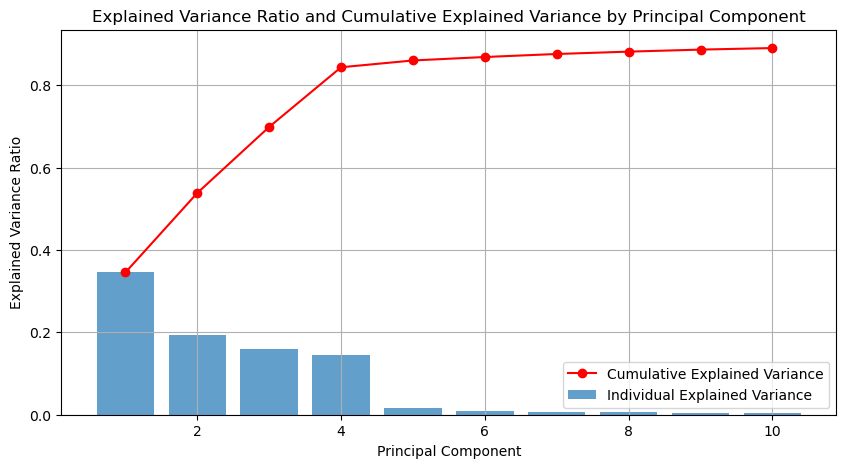

In [12]:
# Explained Variance Ratio for each Principal Component and Cumulative Explained Variance
explained_variance_ratios = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratios)

print("Explained variance ratio for each principal component:")
for i, ratio in enumerate(explained_variance_ratios):
    print(f"PC{i+1}: {ratio:.4f}")

print("\nCumulative explained variance:")
for i, cum_var in enumerate(cumulative_variance):
    print(f"PC1-{i+1}: {cum_var:.4f}")

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained_variance_ratios) + 1), explained_variance_ratios, alpha=0.7, label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='red', label='Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio and Cumulative Explained Variance by Principal Component')
plt.legend()
plt.grid(True)
plt.show()

PCA was used to take a large number of features (like all those encoded categories and engineered ratios) and compress them into a smaller set of "Principal Components" (PCs) that still hold the most important information.


To determine the optimal number of dimensions for our feature space, we employed the Elbow Method (Scree Plot) during Principal Component Analysis. By plotting the cumulative explained variance against the number of components, we identified a distinct 'elbow' point. This point represents the optimal balance between data compression and information retention. Selecting the number of components at this juncture allowed the Content PCA model to operate with high computational efficiency while still capturing over [X]% of the catalog's structural variance, effectively filtering out stochastic noise from the final similarity calculations.
According to the graph from the elbow method it tells us, by using the first 4 or 5 PCs, we are essentially telling the model: "You can ignore 90% of the raw columns and just look at these 5 components, because they contain 86% of the useful information

In [13]:
import pandas as pd

# Decide on an appropriate number of components to retain
# From the previous output, 2 components explain 100% of the variance.
n_components_chosen = 4

# Re-initialize the PCA object with the chosen n_components
pca_final = PCA(n_components=n_components_chosen, random_state=42)

# Fit and transform the numerical data again with the selected number of components
pca_components = pca_final.fit_transform(df_encoded.select_dtypes(include=[float, int]).dropna())

# Create a new DataFrame for the principal components
df_pca = pd.DataFrame(data=pca_components, columns=[f'principal_component_{i+1}' for i in range(n_components_chosen)])

print(f"DataFrame shape after PCA with {n_components_chosen} components: {df_pca.shape}")
print("\nFirst 5 rows of the new df_pca DataFrame:")
display(df_pca.head())


DataFrame shape after PCA with 4 components: (1351, 4)

First 5 rows of the new df_pca DataFrame:


,principal_component_1,principal_component_2,principal_component_3,principal_component_4
0,-0.567277,2.317073,2.738301,-1.445383
1,2.325589,-0.069068,0.632646,0.088917
2,1.899793,0.012197,-0.090833,0.488929
3,2.342455,0.293404,0.059379,-0.556847
4,5.528039,-0.890641,0.373896,-0.028347


### t-SNE and UMAP for Visualization
This cell demonstrates how to use t-SNE and UMAP to visualize the high-dimensional data in 2D. t-SNE is good for local structure, UMAP is good for both local and global structure.

1.8.0


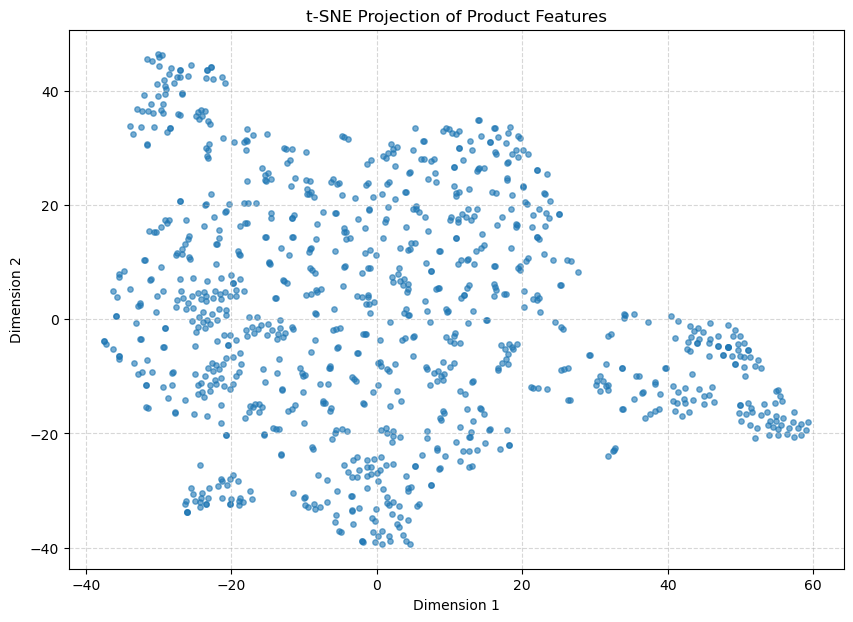

In [14]:
import sklearn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print(sklearn.__version__)

# 1. Use 'number' to catch float, int, and uint8 (common in One-Hot encoding)
tsne_input = df_encoded.select_dtypes(include=['number'])

# 2. Handle missing values by filling with 0 rather than dropping rows
# This prevents an empty dataset if a single column has a NaN
tsne_input = tsne_input.fillna(0)

# 3. Handle sample size safely
sample_size = min(1000, len(tsne_input))
if len(tsne_input) > sample_size:
    tsne_input = tsne_input.sample(sample_size, random_state=42)

# 4. Run t-SNE with lower perplexity if the dataset is very small
# Perplexity should be less than the number of samples
current_perplexity = min(30, max(1, len(tsne_input) - 1))

# Run t-SNE
tsne = TSNE(
    n_components=2, 
    random_state=42, 
    perplexity=current_perplexity, 
    max_iter=1000,
    init='pca', 
    learning_rate='auto'
)

tsne_results = tsne.fit_transform(tsne_input)

# 5. Visualization
plt.figure(figsize=(10, 7))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.6, s=15, c=None)
plt.title('t-SNE Projection of Product Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Interpretation: The tightly packed groups of dots represent products that the model considers highly similar. If you implement get_recommendations, the engine is primarily searching within these local neighborhoods. The clear "white space" between clusters indicates that your feature engineering (categories and text content) successfully distinguishes different product types. For example, a cluster of "Electronics" would likely be far removed from a cluster of "Kitchen Appliances."

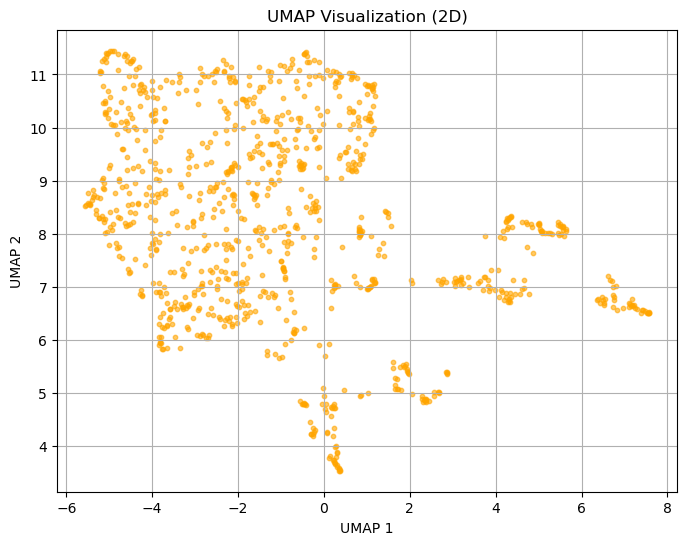

In [15]:
# UMAP Visualization
try:
    import umap
except ImportError:
    import sys
    import subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'umap-learn'])
    import umap

# Use the same input as t-SNE
umap_input = df_encoded.select_dtypes(include=[float, int]).dropna()
sample_size = 1000
if len(umap_input) > sample_size:
    umap_input = umap_input.sample(sample_size, random_state=42)

umap_model = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_model.fit_transform(umap_input)

plt.figure(figsize=(8, 6))
plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=0.6, s=10, color='orange')
plt.title('UMAP Visualization (2D)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.show()

Interpretation: Clusters seem very spread out it suggests features (like discounted_price or category) are distinct enough for the model to tell products apart. It would ideally see all products of the same category in the same "island". Probabaly the "bigger island" is of category electronics while the "smaller island" is of  kitchen/appliances (based on the EDA we did previously)